In [1]:
# !git clone https://github.com/CMU-Perceptual-Computing-Lab/panoptic-toolbox
# %cd panoptic-toolbox
# !./scripts/getData.sh 171204_pose1_sample
# !./scripts/extractAll.sh 171204_pose1_sample

In [22]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# ------------------------------------------------------------------------------

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
import argparse
import os
import pprint
import logging
import json
import sys
import copy

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


# this_dir = osp.dirname(__file__)
this_dir = os.getcwd()

# lib_path = osp.join(this_dir, '..', 'lib')
lib_path = os.path.join(this_dir, 'lib')
add_path(lib_path)

In [3]:
# import _init_paths
from core.config import config
from core.config import update_config
from core.function import train_3d, validate_3d
from utils.utils import create_logger
from utils.utils import save_checkpoint, load_checkpoint, load_model_state
from utils.utils import load_backbone_panoptic
import dataset
import models

/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [4]:
def parse_args(argstring):
    parser = argparse.ArgumentParser(description='Train keypoints network')
    parser.add_argument(
        '--cfg', help='experiment configure file name', required=True, type=str)

    args, rest = parser.parse_known_args(argstring)
    update_config(args.cfg)

    return args

In [5]:
args = parse_args(['--cfg', 'configs/panoptic/hrnet-w48/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION_HICT_6x10x2.yaml'])

In [6]:
###################################################
config.DATASET.GRID_ZROTATION_AUGMENTATION = True
config.DATASET.SPACE_XYTRANSLATION_AUGMENTATION = True
####################################################

In [7]:
gpus = [int(i) for i in config.GPUS.split(',')]
print('=> Loading data ..')
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

=> Loading data ..


In [51]:
config.TEST.BATCH_SIZE = 2

In [52]:
test_dataset = eval('dataset.' + config.DATASET.TEST_DATASET)(
    config, config.DATASET.TEST_SUBSET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE * len(gpus),
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True)


# train_dataset = eval('dataset.' + config.DATASET.TRAIN_DATASET)(
#     config, config.DATASET.TRAIN_SUBSET, False,
#     transforms.Compose([
#         transforms.ToTensor(),
#         normalize,
#     ]))

# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=config.TEST.BATCH_SIZE * len(gpus),
#     shuffle=True,
#     num_workers=config.WORKERS,
#     pin_memory=True)



data_loader = test_loader
# data_loader = train_loader

In [53]:
config.TEST.BATCH_SIZE

2

In [54]:
test_dataset.__len__()

2952

In [55]:
with torch.no_grad():
    for i, (inputs, targets_2d, weights_2d, targets_3d, meta, input_heatmap) in enumerate(data_loader):
        print(len(inputs))
        
        break

5


In [76]:
import cv2
import numpy as np
from utils.transforms import affine_transform, get_scale, get_affine_transform

def make_augmented_inputs(_meta, _transform, random_range=[0.2, 1.0]):
    _inputs_new = []
    _inputs_vis = []
    
    _num_cam = len(_meta)
    _batch_size = len(_meta[0]['image'])
    
    for _cam_i in range(_num_cam):
        input_batch_holder = []
        for _batch_i in range(_batch_size):
    #         print(_meta[_cam_i]['image'][_batch_i])
            data_numpy = cv2.imread(_meta[_cam_i]['image'][_batch_i], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
            data_numpy = cv2.cvtColor(data_numpy, cv2.COLOR_BGR2RGB)
            height, width, _ = data_numpy.shape

            # CAHNGE INPUT FOCAL
            fx = _meta[_cam_i]['camera']['fx'][_batch_i].detach().cpu().numpy()
            fy = _meta[_cam_i]['camera']['fy'][_batch_i].detach().cpu().numpy()
            cx = _meta[_cam_i]['camera']['cx'][_batch_i].detach().cpu().numpy()
            cy = _meta[_cam_i]['camera']['cy'][_batch_i].detach().cpu().numpy()

            f_random_ratio = np.random.rand()*(random_range[1]-random_range[0]) + random_range[0] # (0.2 ~ 1.0)
    #         target_fx = 533.3333
    #         target_fy = 533.3333
            target_fx = f_random_ratio * fx
            target_fy = f_random_ratio * fy

            # affine = np.array([[target_fx/fx,0.,cx/2.-960/2.],
            #                    [0.,target_fy/fy,cy/2.-512/2.]])

            affine = np.array([[target_fx/fx,0.,(cx - cx * (target_fx/fx))],
                               [0.,target_fy/fy,(cy - cy * (target_fy/fy))]])

            data_numpy = cv2.warpAffine(
                        data_numpy,
                        affine, (0, 0),
                        flags=cv2.INTER_LINEAR)

    #         _meta[_cam_i]['camera']['fx'] *= target_fx/fx
    #         _meta[_cam_i]['camera']['fy'] *= target_fy/fy
            _meta[_cam_i]['camera']['fx'][_batch_i] *= target_fx/fx
            _meta[_cam_i]['camera']['fy'][_batch_i] *= target_fy/fy

            c = np.array([width / 2.0, height / 2.0])
            s = get_scale((width, height), [960,512])
            r = 0
            trans = get_affine_transform(c, s, r, [960,512])

            input = cv2.warpAffine(
                        data_numpy,
                        trans, (int(960), int(512)),
                        flags=cv2.INTER_LINEAR)
            input = _transform(input) # 3, 512, 960
            input_batch_holder.append(input)
            
        input_batch_holder = torch.stack(input_batch_holder, dim=0)

#         input = input.unsqueeze(0)

        _inputs_new.append(input_batch_holder)
        _inputs_vis.append(data_numpy)
        
    return _inputs_new, _inputs_vis

In [77]:
# from utils.augmentation_yk import make_augmented_inputs
import torchvision.transforms as transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

In [78]:
meta_new = copy.deepcopy(meta)

In [79]:
inputs_new, inputs_vis = make_augmented_inputs(meta_new, transform, [0.2, 0.6]) # meta changed.

In [80]:
print(len(inputs_new))
print(inputs_new[0].shape)

5
torch.Size([2, 3, 512, 960])


In [10]:
cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

In [11]:
config.BACKBONE_MODEL = 'pose_hrnet'

In [12]:
# config.BACKBONE_MODEL = 'pose_resnet'

In [13]:
# model = models.multi_person_posenet.get_multi_person_pose_net(config, is_train=True)

In [14]:
print('=> Constructing models ..')
model = eval('models.' + config.MODEL + '.get_multi_person_pose_net')(
    config, is_train=True)
with torch.no_grad():
    model = torch.nn.DataParallel(model, device_ids=gpus).cuda()

final_output_dir = ""
    
test_model_file = os.path.join(final_output_dir, config.TEST.MODEL_FILE)

=> Constructing models ..
load checkpoint from local path: /workspace/voxelpose-pytorch/data/higher_hrnet48_coco_512x512-60fedcbc_20200712.pth


In [15]:
model.module.backbone

AssociativeEmbedding(
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [16]:
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/inter-checkpoint.pth'
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/inter-checkpoint_20000.pth'

test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint_20000.pth'
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint_0204.pth'

# test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint.pth'
test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint_rot75000.pth'

test_model_file = '/workspace/voxelpose-pytorch/output_HRNET_ASSO/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5_AUGMENTATION/inter-checkpoint_RT_117000.pth'

model.load_state_dict(torch.load(test_model_file), strict=True)
# model.module.load_state_dict(torch.load(test_model_file), strict=True)

<All keys matched successfully>

In [17]:
# test_model_file = '/workspace/voxelpose-pytorch/output/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/model_best.pth.tar'
# test_model_file = '/workspace/voxelpose-pytorch/output_alldata/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/model_best.pth.tar'
# model.module.load_state_dict(torch.load(test_model_file), strict=True)

In [18]:
model.eval()

DataParallel(
  (module): MultiPersonPoseNet(
    (backbone): AssociativeEmbedding(
      (backbone): HRNet(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, ker

In [19]:
from mmpose.core.evaluation import keypoints_from_heatmaps
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [20]:
from utils.transforms import affine_transform, get_scale, get_affine_transform

In [21]:
from utils.augmentation_yk import make_augmented_inputs

In [22]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

In [23]:
# MODEL

with torch.no_grad():
    for i, (inputs, targets_2d, weights_2d, targets_3d, meta, input_heatmap) in enumerate(data_loader):
        if 'panoptic' in config.DATASET.TEST_DATASET:
            
            inputs_new, inputs_vis = make_augmented_inputs(meta, transform, [0.3, 0.6])
#             inputs_new, inputs_vis = make_augmented_inputs(meta, transform, [2.0, 2.2])
            preds, heatmaps, grid_centers, _, _, _ = model(views=inputs_new, meta=meta, targets_2d=None,
                                                      weights_2d=None, targets_3d=None, tmp_dataset=test_dataset)
        print(i)
        break

0


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/workspace/voxelpose-pytorch/lib/models/project_layer.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _center_xyz = torch.tensor(gird_center_copy).to(0)


In [24]:
from core.loss import PerJointMSELoss
criterion = PerJointMSELoss().cuda()
loss_3d = criterion(torch.zeros(1, device=0), torch.zeros(1, device=0))

root_net = model.module.root_net
root_cubes, grid_centers = root_net(heatmaps, meta)
loss_3d = criterion(root_cubes, targets_3d[0].to(0))
print(loss_3d) # e-5 scale.

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [25]:
# # MODEL

# with torch.no_grad():
#     for i, (inputs, targets_2d, weights_2d, targets_3d, meta, input_heatmap) in enumerate(data_loader):
#         if 'panoptic' in config.DATASET.TEST_DATASET:
#             preds, heatmaps, grid_centers, _, _, _ = model(views=inputs, meta=meta, targets_2d=None,
#                                                       weights_2d=None, targets_3d=None)
#         print(i)
#         break

In [26]:
from lib.utils.cameras import unfold_camera_param, project_pose #,project_point_radial

In [27]:
def project_point_radial(x, R, T, f, c, k, p):
    """
    Args
        x: Nx3 points in world coordinates
        R: 3x3 Camera rotation matrix
        T: 3x1 Camera translation parameters
        f: (scalar) Camera focal length
        c: 2x1 Camera center
        k: 3x1 Camera radial distortion coefficients
        p: 2x1 Camera tangential distortion coefficients
    Returns
        ypixel.T: Nx2 points in pixel space
    """
    n = x.shape[0]
    xcam = torch.matmul(R, torch.t(x) - T)
#     xcam = xcam[0]
    y = xcam[:2] / (xcam[2] + 1e-5)

    kexp = k.repeat((1, n))
    r2 = torch.sum(y**2, 0, keepdim=True)
    r2exp = torch.cat([r2, r2**2, r2**3], 0)
    radial = 1 + torch.einsum('ij,ij->j', kexp, r2exp)

    tan = p[0] * y[1] + p[1] * y[0]
    corr = (radial + 2 * tan).repeat((2, 1))

    y = y * corr + torch.ger(torch.cat([p[1], p[0]]).view(-1), r2.view(-1))
    ypixel = (f * y) + c
    return torch.t(ypixel)

In [28]:
_cam_i = 4
_batch_i = 0

preds_np = preds.detach().cpu()
one_pred = preds_np[_batch_i]
detected_idx = one_pred[:, 0, 3] == 0
num_detected = sum(detected_idx)
one_GT_np = meta[_cam_i]['joints_3d'][_batch_i]
GT_ID_idx = one_GT_np[:, 0, 2] != 0. # may causes error
num_GT_ID = sum(GT_ID_idx)
print('num_detected is : {}'.format(num_detected))
print('num_gt is : {}'.format(num_GT_ID))

pred_joint_color = [0, 0, 255]
GT_joint_color = [0, 255, 0]

debug_GT_joint_color = [255, 0, 0]

image = inputs_vis[_cam_i]

for cand in range(num_detected):
    joint_3d = one_pred[cand, :, :3]
# #     joint_3d /= 1000.
    
    camera = meta[_cam_i]['camera']
    R, T, f, c, k, p = unfold_camera_param(camera, device=0)
    R = R.type(torch.torch.float64)
    T = T.type(torch.torch.float64)
    f = f.type(torch.torch.float64)
    c = c.type(torch.torch.float64)
    k = k.type(torch.torch.float64)
    p = p.type(torch.torch.float64)
#     projected_radial_GT = project_point_radial(GT_3d.to(0).type(torch.torch.float64), R[0], T[0], f, c, k[0], p[0])
    projected_radial = project_point_radial(joint_3d.to(0).type(torch.torch.float64), R[0], T[0], f, c, k[0], p[0])

    for joint in range(joint_3d.shape[0]):
        image = cv2.circle(image, (int(projected_radial[joint,0]),int(projected_radial[joint,1])), 0, pred_joint_color, 10)


for GT in range(num_GT_ID):
    GT_3d = one_GT_np[GT, :, :]
    degub_projected_GT = meta[_cam_i]['joints'][_batch_i,GT]
    camera = meta[_cam_i]['camera']
    R, T, f, c, k, p = unfold_camera_param(camera, device=0)
    R = R.type(torch.torch.float64)
    T = T.type(torch.torch.float64)
    f = f.type(torch.torch.float64)
    c = c.type(torch.torch.float64)
    k = k.type(torch.torch.float64)
    p = p.type(torch.torch.float64)
    projected_radial_GT = project_point_radial(GT_3d.to(0).type(torch.torch.float64), R[0], T[0], f, c, k[0], p[0])
#     projected_radial = project_point_radial(joint_3d.to(0).type(torch.torch.float64), R[0], T[0], f, c, k[0], p[0])

    for joint in range(GT_3d.shape[0]):
        image = cv2.circle(image, (int(projected_radial_GT[joint,0]),int(projected_radial_GT[joint,1])), 0, GT_joint_color, 10)



num_detected is : 1
num_gt is : 1


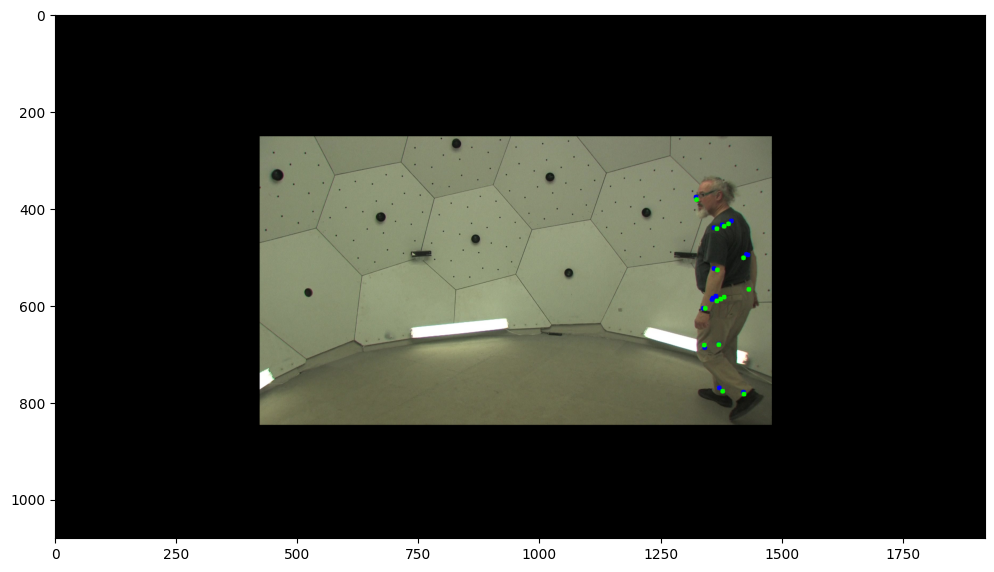

In [29]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(image)

In [30]:
heatmaps[0].shape

torch.Size([1, 15, 256, 480])

In [31]:
heatmap_fig = np.sum(heatmaps[_cam_i][_batch_i].detach().cpu().numpy(), axis=0)
heatmap_fig.shape

(256, 480)

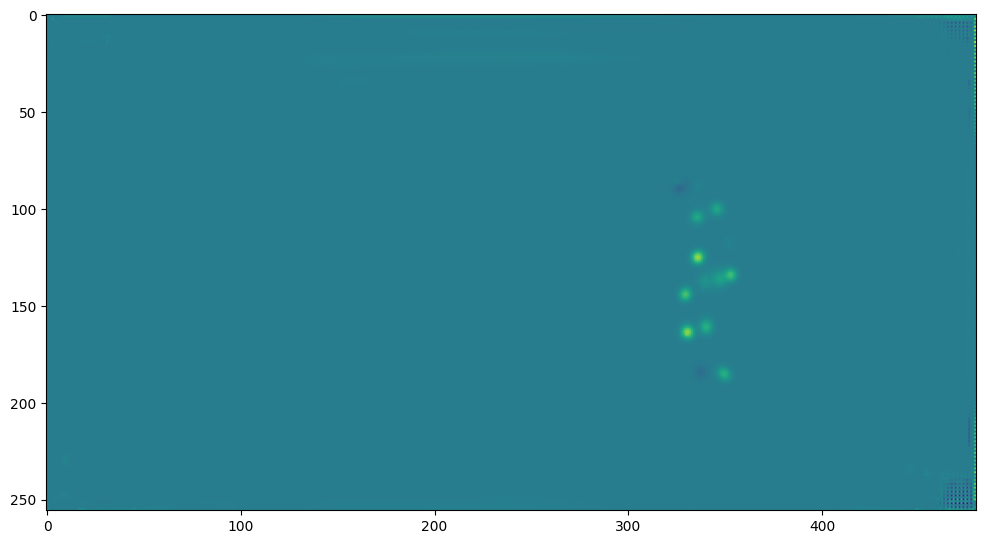

In [32]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(heatmap_fig)